In [19]:
import sys
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from recommenders.datasets.python_splitters import python_random_split, python_stratified_split
from recommenders.models.ncf.ncf_singlenode import NCF
import warnings
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.evaluation.python_evaluation import (
    ndcg_at_k, precision_at_k, recall_at_k, rmse
)
from recommenders.utils.constants import SEED 



In [20]:
# top k items to recommend
TOP_K = 10

# Model parameters
EPOCHS = 100
BATCH_SIZE = 256

In [21]:
ratings = pd.read_csv('books_data/ratings_new.csv')
books = pd.read_csv('books_data/books_new.csv')

In [22]:
english_codes = ['en', 'en-CA', 'en-GB', 'en-US', 'eng']
books = books[books['language_code'].isin(english_codes)]

In [23]:
books_df= pd.merge(books, ratings, on='book_id')


In [24]:
user_ratings_count = books_df.groupby('user_id').size()
item_ratings_count = books_df.groupby('book_id').size()

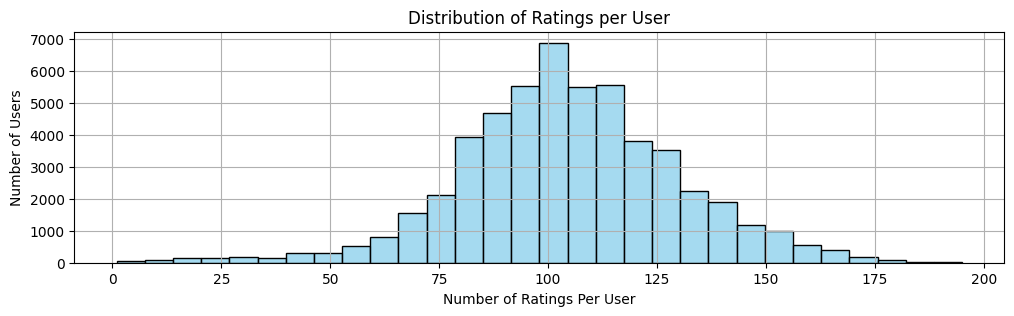

In [25]:
plt.figure(figsize=(12, 3))
sns.histplot(user_ratings_count, bins=30, kde=False, color='skyblue')
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings Per User')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

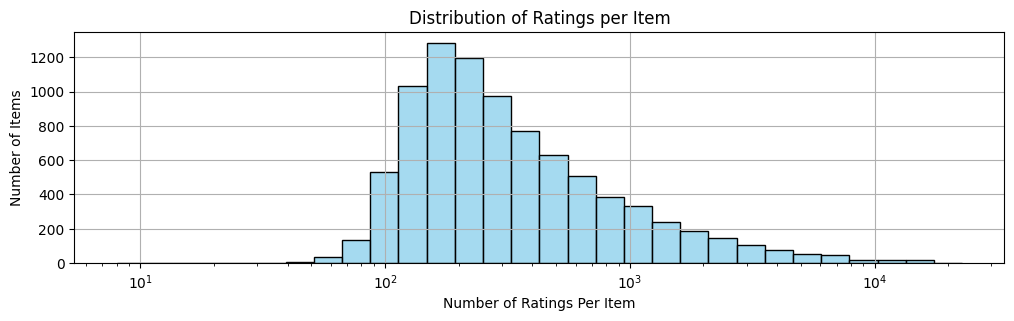

In [26]:
plt.figure(figsize=(12, 3))
sns.histplot(item_ratings_count, bins=30, kde=False, color='skyblue', log_scale=True)
plt.title('Distribution of Ratings per Item')
plt.xlabel('Number of Ratings Per Item')
plt.ylabel('Number of Items')
plt.grid(True)
plt.show()

In [27]:
columns_to_keep = ['user_id', 'book_id', 'authors', 'title', 'rating']
books_df = books_df[columns_to_keep]
books_df.head()
books_df.shape

(5579146, 6)

In [8]:
filtered_book_df = books_df.copy()

In [9]:
user_count = filtered_book_df['user_id'].value_counts()
filtered_book_df = filtered_book_df[filtered_book_df['user_id'].isin(user_count[user_count >= 160].index)]
n_books = books_df['book_id'].nunique()
n_users = books_df['user_id'].nunique()
n_books_new = filtered_book_df['book_id'].nunique()
n_users_new = filtered_book_df['user_id'].nunique()
print(filtered_book_df.shape)
print(f"Before----Users: {n_users}, Books: {n_books}")
print(f"After-----Users: {n_users_new}, Books: {n_books_new}")

(160882, 6)
Before----Users: 53424, Books: 8730
After-----Users: 959, Books: 7595


In [10]:
books_count = filtered_book_df['book_id'].value_counts()
filtered_book_df = filtered_book_df[filtered_book_df['book_id'].isin(books_count[books_count >= 15].index)]
n_books_new = filtered_book_df['book_id'].nunique()
n_users_new = filtered_book_df['user_id'].nunique()
print(filtered_book_df.shape)
print(f"Before----Users: {n_users}, Books: {n_books}")
print(f"After-----Users: {n_users_new}, Books: {n_books_new}")

(134525, 6)
Before----Users: 53424, Books: 8730
After-----Users: 959, Books: 1986


In [11]:
unique_userIds = filtered_book_df['user_id'].unique()
unique_userIds.sort()

# Create a mapping from old userIds to new ones (starting from 1)
user_id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_userIds, start=1)}

# Apply the mapping to the userIds column
filtered_book_df['user_id'] = filtered_book_df['user_id'].map(user_id_mapping)
filtered_book_df.sort_values(by='user_id', ascending=True)

,user_id,book_id,authors,title,rating,isbn
1041232,1,114,"Mitch Albom, Saulius Dagys",Tuesdays with Morrie,2,751529818
3803853,1,1957,Dodie Smith,I Capture the Castle,4,312181108
2641283,1,696,Anne Rice,"The Vampire Lestat (The Vampire Chronicles, #2)",3,345476883
2353727,1,531,"Unknown, Seamus Heaney",Beowulf,2,393320979
1686966,1,264,Ernest Hemingway,The Sun Also Rises,2,743297334
...,...,...,...,...,...,...
2543833,959,637,Ray Bradbury,The Martian Chronicles,5,553278223
886251,959,86,John Grisham,A Time to Kill,5,385338600
3502353,959,1509,"Edith Wharton, Nina Bawden",The House of Mirth,5,1844082938
2284011,959,495,Dave Eggers,A Heartbreaking Work of Staggering Genius,5,375725784


In [12]:
unique_itemIds = filtered_book_df['book_id'].unique()

# Create a mapping from old itemIdsunique_itemIds to new ones (starting from 1)
item_id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_itemIds, start=1)}

# Apply the mapping to the itemIdsunique_itemIds column
filtered_book_df['book_id'] = filtered_book_df['book_id'].map(item_id_mapping)
filtered_book_df.sort_values(by='book_id', ascending=True)

,user_id,book_id,authors,title,rating,isbn
86,143,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",5,439023483
13883,754,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",5,439023483
13752,747,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",4,439023483
13721,752,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",4,439023483
13706,751,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",2,439023483
...,...,...,...,...,...,...
5557047,192,1986,Richard Llewellyn,How Green Was My Valley,2,141185856
5557040,126,1986,Richard Llewellyn,How Green Was My Valley,5,141185856
5557216,671,1986,Richard Llewellyn,How Green Was My Valley,4,141185856
5557080,433,1986,Richard Llewellyn,How Green Was My Valley,4,141185856


In [13]:
n_books = filtered_book_df['book_id'].nunique()
n_users = filtered_book_df['user_id'].nunique()
n_ratings = filtered_book_df.shape[0]


print(f"Number of ratings: {n_ratings}")
print(f"Number of unique books's: {n_books}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per book: {round(n_ratings/n_books, 2)}")

Number of ratings: 134525
Number of unique books's: 1986
Number of unique users: 959
Average number of ratings per user: 140.28
Average number of ratings per book: 67.74


In [16]:
books_final_df = filtered_book_df.copy().drop(["title", "authors"], axis=1) 

In [17]:
train, test = python_stratified_split(books_final_df, col_user="user_id", col_item="book_id")

In [18]:
leave_one_out_test = test.groupby("user_id").last().reset_index()

In [19]:
test = test[test["user_id"].isin(train["user_id"].unique())]
test = test[test["book_id"].isin(train["book_id"].unique())]


In [20]:
print(train['user_id'].nunique())
print(train['book_id'].nunique())

959
1985


In [20]:
print(f"Test set length: {test.shape[0]}")
print(f"Full data length: {train.shape[0] + test.shape[0]}")

Test set length: 33613
Full data length: 134505


In [21]:
train_file = "./train.csv"
test_file = "./test.csv"
leave_one_out_test_file = "./leave_one_out_test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)
leave_one_out_test.to_csv(leave_one_out_test_file, index=False)

In [22]:
data = NCFDataset(train_file=train_file, test_file=leave_one_out_test_file, seed=SEED, col_item="book_id", col_user="user_id", overwrite_test_file_full=True)

INFO:recommenders.models.ncf.dataset:Indexing ./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./leave_one_out_test.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file ./leave_one_out_test_full.csv ...
100%|██████████| 959/959 [00:10<00:00, 88.27it/s] 
INFO:recommenders.models.ncf.dataset:Indexing ./leave_one_out_test_full.csv ...


In [32]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

def print_progress(study, trial):
    print(f"Trial {trial.number + 1} finished with value: {trial.value} and parameters: {trial.params}.")
    print(f"Best value so far: {study.best_trial.value}")


def objective(trial):
    # Define the hyperparameter space
    n_factors = trial.suggest_categorical('n_factors', [12, 16, 20, 24])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    
    # Create the model with these hyperparameters
    model = NCF(
        n_users=data.n_users, 
        n_items=data.n_items,
        model_type="NeuMF",
        n_factors=n_factors,
        layer_sizes=[16,8,4],
        n_epochs=10,  # Reduced for speed in tuning
        batch_size=batch_size,
        learning_rate=learning_rate,
        verbose=0,
        seed=SEED
    )
    model.fit(data)
    
    # Make predictions and calculate precision@k
    users, items, preds = [], [], []
    item = list(train.book_id.unique())
    for user in train.user_id.unique():
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"user_id": users, "book_id": items, "prediction": preds})
    merged = pd.merge(train, all_predictions, on=["user_id", "book_id"], how="outer")
    test_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

    eval_precision = precision_at_k(test, test_predictions, col_prediction='prediction', col_item="book_id", col_user="user_id", k=TOP_K)
    return eval_precision

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, callbacks=[print_progress])

print("Best parameters: ", study.best_params)
print("Best precision@k: ", study.best_value)

Trial 1 finished with value: 0.2873826903023984 and parameters: {'n_factors': 20, 'learning_rate': 0.0009588101864031113, 'batch_size': 64}.
Best value so far: 0.2873826903023984
Trial 2 finished with value: 0.27966631908237755 and parameters: {'n_factors': 20, 'learning_rate': 0.00020710950541699764, 'batch_size': 32}.
Best value so far: 0.2873826903023984
Trial 3 finished with value: 0.23044838373305526 and parameters: {'n_factors': 12, 'learning_rate': 0.0002275813001438651, 'batch_size': 128}.
Best value so far: 0.2873826903023984
Trial 4 finished with value: 0.10323253388946821 and parameters: {'n_factors': 16, 'learning_rate': 1.0104090048880248e-05, 'batch_size': 128}.
Best value so far: 0.2873826903023984
Trial 5 finished with value: 0.17789363920750784 and parameters: {'n_factors': 16, 'learning_rate': 8.81034382862591e-05, 'batch_size': 128}.
Best value so far: 0.2873826903023984
Trial 6 finished with value: 0.289051094890511 and parameters: {'n_factors': 20, 'learning_rate':

In [31]:
def base():
    model = NCF(
        n_users=data.n_users, 
        n_items=data.n_items,
        model_type="NeuMF",
        n_factors=4,
        layer_sizes=[16,8,4],
        n_epochs=10,
        batch_size=BATCH_SIZE,
        learning_rate=1e-3,
        verbose=5,
        seed=SEED
    )

    model.fit(data)

    users, items, preds = [], [], []
    item = list(train.book_id.unique())
    for user in train.user_id.unique():
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"user_id": users, "book_id": items, "prediction": preds})
    merged = pd.merge(train, all_predictions, on=["user_id", "book_id"], how="outer")
    test_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

    eval_precision = precision_at_k(test, test_predictions, col_prediction='prediction', col_item="book_id", col_user="user_id", k=TOP_K)

    return eval_precision

base()

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [14.16s]: train_loss = 0.347564 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [13.14s]: train_loss = 0.329117 


0.21689259645464026

In [33]:
model = NCF(
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=20,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=32,
    learning_rate=0.0005778618758548964,
    verbose=1,
    seed=SEED
)

In [34]:
model.fit(data)

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [68.24s]: train_loss = 0.415732 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [63.90s]: train_loss = 0.355161 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [65.38s]: train_loss = 0.327511 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [66.60s]: train_loss = 0.310229 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [65.77s]: train_loss = 0.297114 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [64.93s]: train_loss = 0.288501 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [59.74s]: train_loss = 0.282682 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [58.38s]: train_loss = 0.277325 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [61.06s]: train_loss = 0.273223 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [56.80s]: train_loss = 0.269370 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 11 [58.30s]: train_loss = 0.265797 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 12 [57.87s]: 

In [35]:
users, items, preds = [], [], []
item = list(train.book_id.unique())
for user in train.user_id.unique():
    user = [user] * len(item) 
    users.extend(user)
    items.extend(item)
    preds.extend(list(model.predict(user, item, is_list=True)))

all_predictions = pd.DataFrame(data={"user_id": users, "book_id":items, "prediction":preds})

merged = pd.merge(train, all_predictions, on=["user_id", "book_id"], how="outer")
all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

In [36]:
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', col_item="book_id", col_user="user_id", k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction',  col_item="book_id", col_user="user_id", k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction',  col_item="book_id", col_user="user_id", k=TOP_K)

print(
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG:	0.302936
Precision@K:	0.284567
Recall@K:	0.082342


In [37]:
def calculate_f1_score(precision_at_k, recall_at_k):
    """
    Calculate the F1 score from Precision@K and Recall@K.

    Args:
        precision_at_k (float): Precision at K.
        recall_at_k (float): Recall at K.

    Returns:
        float: The F1 score calculated from Precision@K and Recall@K.
    """
    # Check for cases where both precision and recall are zero.
    if precision_at_k + recall_at_k == 0:
        return 0.0
    
    f1_score = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
    return f1_score

In [38]:
calculate_f1_score(eval_precision, eval_recall)

0.1277250525733333

In [39]:
k = TOP_K

ndcgs = []
hit_ratio = []

for b in data.test_loader():
    user_input, item_input, labels = b
    output = model.predict(user_input, item_input, is_list=True)

    output = np.squeeze(output)
    rank = sum(output >= output[0])
    if rank <= k:
        ndcgs.append(1 / np.log(rank + 1))
        hit_ratio.append(1)
    else:
        ndcgs.append(0)
        hit_ratio.append(0)

eval_ndcg = np.mean(ndcgs)
eval_hr = np.mean(hit_ratio)

print("HR:\t%f" % eval_hr)
print("NDCG:\t%f" % eval_ndcg)

HR:	0.482795
NDCG:	0.364497
